# Exploring MovieLens

Three part:
- clustering

## The data

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ratings = pd.read_csv('data/ml-100k/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


We are not going to use timestamp for now

In [3]:
ratings = ratings.drop(['timestamp'], axis=1)

In [4]:
ratings.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [5]:
movies = pd.read_csv('data/ml-100k/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
tags = pd.read_csv('data/ml-100k/tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [7]:
links = pd.read_csv('data/ml-100k/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


What do you think?
- ratings data: 
 - I can cluster users based on how they rate movies
 - I can cluster movies based on how they rated by users
- movies data:
 - I can custer movies based on genres characteristic (since most movies has more that one genres). It is very useful

# Moves data
I assume the genres can be considered as features. And they are independent of each other

We can make a sparse matrix or DataFrame with:
- rows: the movieId
- columns: all genres

In order to do that, we need to make a set of all genres, make them a list so we can use them as column. Parse the genres of each movies and make a dictionary with key is the movieId and the list of genres it's have as the value. After that, we need to make a script to convert that dictionary into DataFrame with value either 0 or 1, 1 if the movie has the genres 0 otherwise (somehow it's like multi-label).

In [9]:
movieIds = movies['movieId'].unique()
len(movieIds)

9125

In [74]:
movie_genres = {}
for movieId in movieIds:
    genres = movies[movies['movieId'] == movieId]['genres'].values[0].split('|')
    movie_genres[movieId] = genres

In [75]:
all_genres = []
for movieId in movie_genres:
    all_genres += movie_genres[movieId]
all_genres = set(all_genres)
all_genres = list(all_genres)

In [76]:
all_genres

['Animation',
 'Action',
 'Adventure',
 'Crime',
 'Fantasy',
 'Drama',
 'Documentary',
 'Thriller',
 'Comedy',
 'IMAX',
 'Film-Noir',
 'Musical',
 'Romance',
 'Sci-Fi',
 'Children',
 '(no genres listed)',
 'Mystery',
 'War',
 'Western',
 'Horror']

In [77]:
len(all_genres)

20

Do we need to cluster the movies based on their genres? How much combination of it if we not cluster them? all genres would be 19 + 1 no genres listed. Example: drama comedy movies, horror thriller movies, etc.

thanks to: https://stackoverflow.com/questions/37862139/convert-dictionary-to-sparse-matrix

In [78]:
df_movie_genres = pd.DataFrame.from_dict(movie_genres, orient='index')
df_movie_genres = df_movie_genres.stack().reset_index()
df_movie_genres.level_1 = 1
df_movie_genres = df_movie_genres.pivot(index='level_0', columns=0, values='level_1').fillna(0)
df_movie_genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
level_0,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's first see the count of each genres

In [79]:
count_genres = {}
for genre in df_movie_genres.columns:
    count_genres[genre] = df_movie_genres[genre].sum()
    
count_genres

{'(no genres listed)': 18.0,
 'Action': 1545.0,
 'Adventure': 1117.0,
 'Animation': 447.0,
 'Children': 583.0,
 'Comedy': 3315.0,
 'Crime': 1100.0,
 'Documentary': 495.0,
 'Drama': 4365.0,
 'Fantasy': 654.0,
 'Film-Noir': 133.0,
 'Horror': 877.0,
 'IMAX': 153.0,
 'Musical': 394.0,
 'Mystery': 543.0,
 'Romance': 1545.0,
 'Sci-Fi': 792.0,
 'Thriller': 1729.0,
 'War': 367.0,
 'Western': 168.0}

In [83]:
import operator
sorted_count_genres = sorted(count_genres.items(), key=operator.itemgetter(1))

In [84]:
sorted_count_genres

[('(no genres listed)', 18.0),
 ('Film-Noir', 133.0),
 ('IMAX', 153.0),
 ('Western', 168.0),
 ('War', 367.0),
 ('Musical', 394.0),
 ('Animation', 447.0),
 ('Documentary', 495.0),
 ('Mystery', 543.0),
 ('Children', 583.0),
 ('Fantasy', 654.0),
 ('Sci-Fi', 792.0),
 ('Horror', 877.0),
 ('Crime', 1100.0),
 ('Adventure', 1117.0),
 ('Action', 1545.0),
 ('Romance', 1545.0),
 ('Thriller', 1729.0),
 ('Comedy', 3315.0),
 ('Drama', 4365.0)]

In [80]:
df_movie_genres_values = df_movie_genres.values
df_movie_genres_values

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

We can further analyse the __correlation between genres__

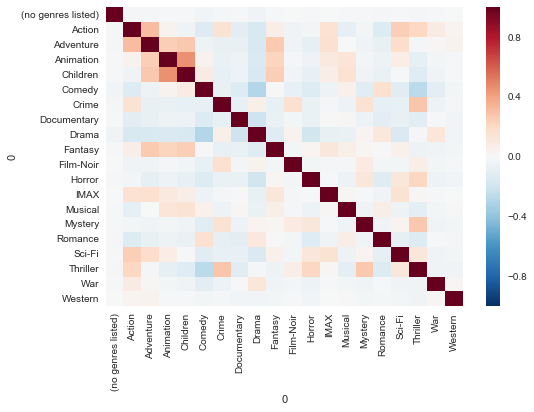

In [98]:
ax = sns.heatmap(df_movie_genres.corr())

Why drama has negative correlation with comedy?? I know there's many drama-comedy movies man. how?

Let's try __PCA__

In [38]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components=2)
X_movie_pca = pca.fit_transform(df_movie_genres_values)

In [46]:
X_movie_pca.shape

(9125, 2)

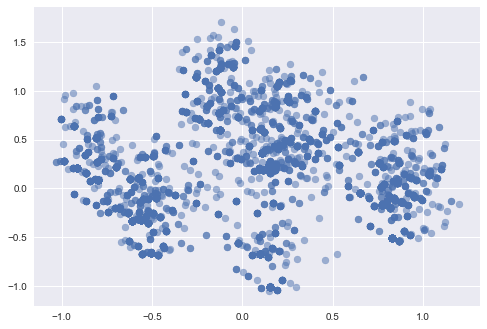

In [91]:
plt.scatter(X_movie_pca[:,0], X_movie_pca[:,1], alpha=0.5)

There is about 4 big blobs but there is a lot of small thick dots there. That means a lot of movies that has exactly the same genres. We can see those thick dots if we reduce the alpha more.

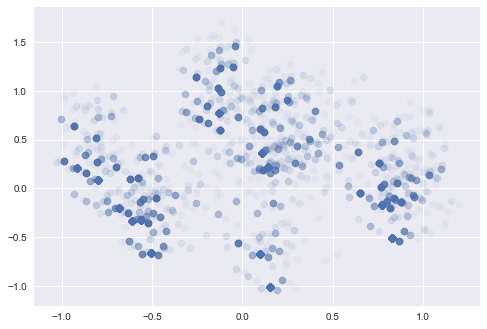

In [90]:
plt.scatter(X_movie_pca[:,0], X_movie_pca[:,1], alpha=0.05)

https://seaborn.pydata.org/examples/multiple_joint_kde.html

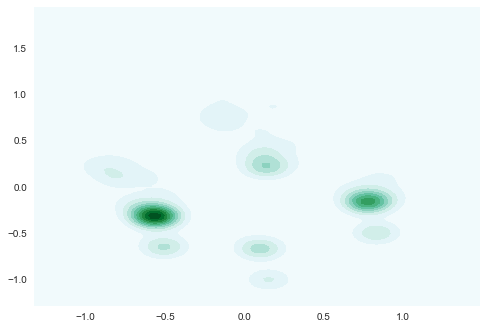

In [96]:
f, ax = plt.subplots()
ax = sns.kdeplot(X_movie_pca[:,0], X_movie_pca[:,1], shade=True)

Let's try __t-SNE__. Becareful, I tried to put all the data to the t-SNE and my laptop is crashed. Still don't know why that happened. So I only try 1000 example and it runs. Maybe the problem is that t-SNE cannot process to much row in the data?

In [19]:
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE(n_components=2, n_iter = 200)
X_movie_tsne = tsne.fit_transform(df_movie_genres_values[0:1000])

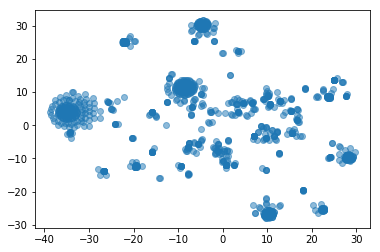

In [28]:
plt.scatter(X_movie_tsne[:,0], X_movie_tsne[:,1], alpha=0.5)



Let's try to __cluster__ those movies. Since there's a problem with the t-SNE, I will use the PCA result. Maybe I need more understanding about the difference between PCA and t-SNE since it is really important for the interpretation.

From the 2D pca result, I think 4 cluster is good? Let's try and interpret.

In [29]:
from sklearn.mixture import GaussianMixture

In [48]:
gm_movies_pca = GaussianMixture(4).fit(X_movie_pca)
cluster_movie_genres = gm_movies_pca.predict(X_movie_pca)

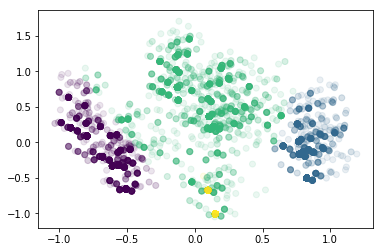

In [49]:
plt.scatter(X_movie_pca[:,0], X_movie_pca[:,1], c=cluster_movie_genres, alpha=0.1)

Seem's like we have weird cluster label result. I've checked the code and I think nothing's wrong. The problem is __I don't know how Gaussian Mixture clustering algo works__. The result is definitely different with what I think k-means would do.

In [52]:
df_movie_genres['cluster_movie_genres'] = cluster_movie_genres

In [54]:
df_movie_genres['cluster_movie_genres'].value_counts()

0    3248
2    2983
1    2203
3     691
Name: cluster_movie_genres, dtype: int64

We can plot the total count sum of each cluster. We can do it by group by! The resulting would be cluster as row (only 4) and genres as columns and sum of count as value.

In [62]:
df_movie_genres_gb = df_movie_genres.groupby('cluster_movie_genres')[all_genres].mean()
df_movie_genres_gb

,Animation,Action,Adventure,Crime,Fantasy,Drama,Documentary,Thriller,Comedy,IMAX,Film-Noir,Musical,Romance,Sci-Fi,Children,(no genres listed),Mystery,War,Western,Horror
cluster_movie_genres,,,,,,,,,,,,,,,,,,,,
0,0.006158,0.096675,0.037562,0.162254,0.028941,1.000000,0.006158,0.223214,0.000000,0.005234,0.024323,0.026170,0.185037,0.036946,0.013547,0.000000,0.080973,0.075123,0.016318,0.043719
1,0.082161,0.101226,0.129369,0.052655,0.088516,0.000000,0.017703,0.002724,1.000000,0.009986,0.000000,0.067635,0.224694,0.055833,0.124830,0.000000,0.012710,0.012256,0.018157,0.045393
2,0.082467,0.337915,0.238015,0.153201,0.122360,0.142809,0.146162,0.334563,0.141133,0.038217,0.018103,0.053637,0.061683,0.183708,0.088502,0.006034,0.084479,0.031847,0.024807,0.212873
3,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.383502,0.001447,0.000000,0.000000,0.000000,0.001447,0.001447,0.000000


In [64]:
df_movie_genres_gb_values = df_movie_genres_gb.values

In [65]:
import seaborn as sns

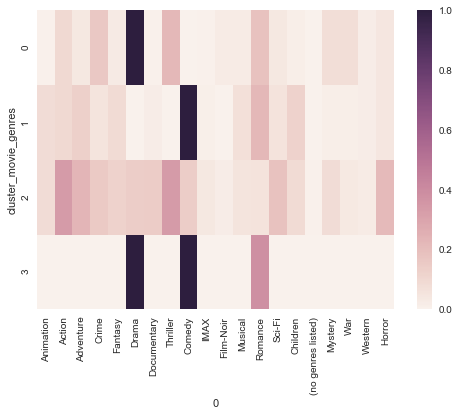

In [67]:
ax = sns.heatmap(df_movie_genres_gb)

# Ratings data

In [15]:
len(ratings['userId'].unique()), len(ratings['movieId'].unique()), len(ratings['rating'].unique())

(671, 9066, 10)

Making pivot table, There can be two modes I think that can be usefull to study

1. The first can be usefull to cluster the users:
 - users: userId
 - columns: movieId
 - value: rating
    
- The second can be usefull to cluster the movies
 - rows: movieId
 - columns: userId
 - value: rating

I always forget to do pivot table in Python, here we go the docs:

# User clustring
steps:
1. making pivot table, here we use The FTrst
2. dimensional reduction, can be 2 ways:
 - using PCA to reduce dim to 50, then use t-SNE to futher reduce from 50 to 2
 - directly using t-SNE
3. use clustering algo to cluster the users
4. interpret the clusters of users

In [24]:
ratings_pvt = pd.pivot_table(ratings, values='rating', index='userId', columns='movieId', fill_value=0)
ratings_pvt.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


In [25]:
ratings_pvt.values.shape

(671, 9066)

## Dimensionality Reduction

### PCA

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
ratings_pvt_values = ratings_pvt.values

In [38]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ratings_pvt_values)

In [39]:
X_pca.shape

(671, 2)

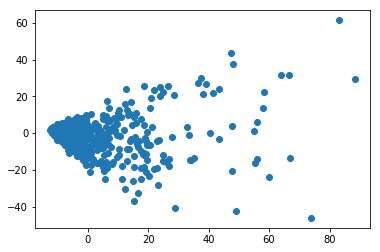

In [40]:
plt.scatter(X_pca[:,0], X_pca[:,1])

## t-SNE

how to set up a t-sne? Here's some reference to read:

In [94]:
from sklearn.manifold import TSNE

In [95]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ratings_pvt_values)

In [96]:
X_tsne.shape

(671, 2)

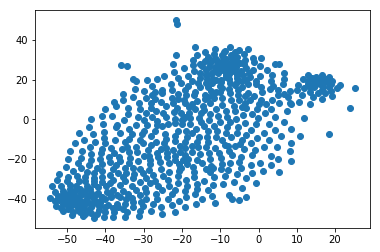

In [97]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

In [66]:
tsne_p50 = TSNE(n_components=2, perplexity=50)
X_tsne_p50 = tsne_p50.fit_transform(ratings_pvt_values)

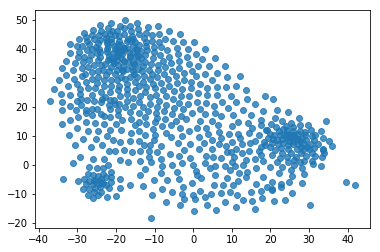

In [67]:
plt.scatter(X_tsne_p50[:,0], X_tsne_p50[:,1], alpha=0.8)

What the hell?

In [58]:
pca_50 = PCA(n_components=50)
X_pca_50 = pca_50.fit_transform(ratings_pvt_values)

In [59]:
X_pca_50.shape

(671, 50)

In [63]:
X_tsne_p50_pca = tsne_p50.fit_transform(X_pca_50)

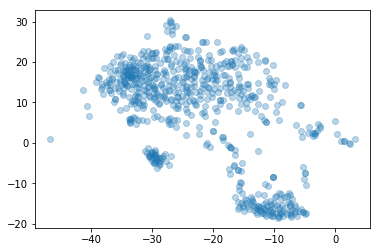

In [65]:
plt.scatter(X_tsne_p50_pca[:,0], X_tsne_p50_pca[:,1], alpha=0.3)

## Unsupervised Clustering

Let's see both:
- X_tsne_p50
- X_tsne_p50_pca

### Gaussian Mixture

In [73]:
from sklearn.mixture import GaussianMixture

#### X_tsne_p50

In [88]:
gm_p50 = GaussianMixture(3)
gm_p50.fit(X_tsne_p50)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [89]:
cluster_label_p50 = gm_p50.predict(X_tsne_p50)

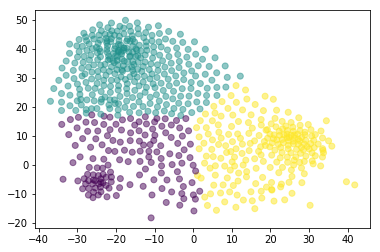

In [90]:
plt.scatter(X_tsne_p50[:, 0], X_tsne_p50[:, 1], c=cluster_label_p50, alpha=0.5)

#### X_tsne_p50_pca

In [91]:
gm_p50_pca = GaussianMixture(4)
gm_p50_pca.fit(X_tsne_p50_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=4, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [92]:
cluster_label_p50_pca = gm_p50_pca.predict(X_tsne_p50_pca)

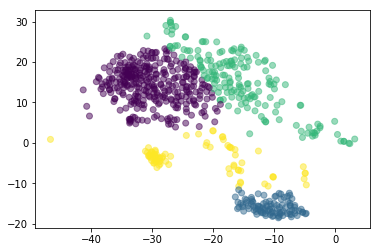

In [93]:
plt.scatter(X_tsne_p50_pca[:, 0], X_tsne_p50_pca[:, 1], c=cluster_label_p50_pca, alpha=0.5)

I don't know what is better way to cluster this

## Interpret the cluster

From the available data, what is the characteristic of user that we can used?
- the data is about the users rate the movies. But it is bad to just see the characteristic of user based on movie id. you know what i mean.
- the movies has genre characteristic. So it might be good to see the characteristic of user based on the genre